Simple single dense layer architecture of neutral network
import dependencies

In [4]:
import os
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential


from tensorflow.keras.layers import Embedding,Dense
from tensorflow.keras.layers import SpatialDropout1D,Conv1D,GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten,Dropout

from tensorflow.keras.callbacks import ModelCheckpoint


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import nltk,re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve 




Basic text prepocessing function

In [5]:
def preprocessing_txt(list_of_sents:pd)->list:
    
    df_sents = list_of_sents
    lemmatizer = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    new_list_sents = []
    for sents in df_sents:   
        tokens = word_tokenize(sents)
        words = " ".join([lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() or word not in stop_words]) 
        new_list_sents.append(words)

    return new_list_sents
    



read file and constructed feature engineered data X and proper encoded labels y

In [6]:
replace_initial = "someone"
df= pd.read_csv("data-processed.csv")
X_raw = df["DESCRIPTION"]
X_rnm = pd.array([re.sub(r"\{\{[^\{\}]+\}\}\w?", replace_initial, str1) for str1 in X_raw])
X_ = preprocessing_txt(X_rnm)
Y_ = np.array([1 if t == 'Medical emergency' else 0 for t in df["INCIDENT_TYPE_1"]])


Here we use sklearn split function to seperate train and test data at 80% and 20%

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X_,Y_,train_size = 0.80, random_state = 1, shuffle = True)
X_test

['not long after 1pm the fire alarm went off at providence . i doubled checked the kitchen to confirm the oven wa off and it wa . something in my gut told me to check unit 201 . the resident that life there left very quickly 2 minute earlier and had left in such a manner i noticed and remembered . a soon a i got to the 2nd floor i smelt smoke . i used my foot to open the door and a huge cloud of smoke came out . i immediately called 911 and alerted the other resident to get out of the building',
 'someone entered the hallway and someone began yelling at her and getting in her face , staff intervened and asked the woman to separate , someone entered the office someone followed her and threatened to beat her up right in the office , someone remained silent . someone began yelling at writer and refused to leave the office , someone yelled in writer face until she left the office . someone then brought 3 guest into the building despite knowing she is not allowed guest , someone wa called a

Here we use tensorflow tokenizer. The unique function we explore here is the oov_token which represent unknown words, in our cases it should provide some better representation since we will be using embedding word vector.

In [8]:
tokenizer = Tokenizer(num_words=None,
                    lower =True,oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
unique_words = len(tokenizer.word_index)+1

Here we further prepare our text tokens be ready for embedding layers by two techniques:
1. texts to sequences: It encodes word tokens into digits as you can see in word_index below 
2. padded text: it is basic fill up the space to match to all same length. here I did not restrict my max words in padding to capture all word count. 

In [9]:
train_sequences = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(train_sequences,padding = "post")

test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(test_sequences,padding = "post")
max_len = len(padded_test[0])
tokenizer.word_index


{'<oov>': 1,
 'someone': 2,
 'and': 3,
 'to': 4,
 'the': 5,
 'wa': 6,
 'staff': 7,
 'her': 8,
 'a': 9,
 'she': 10,
 'at': 11,
 'that': 12,
 'writer': 13,
 'in': 14,
 'called': 15,
 'with': 16,
 'on': 17,
 'of': 18,
 'arrived': 19,
 'client': 20,
 'hospital': 21,
 'for': 22,
 'came': 23,
 'not': 24,
 'had': 25,
 'they': 26,
 "'s": 27,
 'went': 28,
 'police': 29,
 'from': 30,
 'call': 31,
 'asked': 32,
 'took': 33,
 '911': 34,
 'up': 35,
 'this': 36,
 'unit': 37,
 'building': 38,
 'room': 39,
 'but': 40,
 'office': 41,
 'guest': 42,
 'go': 43,
 'left': 44,
 'pain': 45,
 'did': 46,
 'is': 47,
 'back': 48,
 'stated': 49,
 'when': 50,
 'were': 51,
 'he': 52,
 'check': 53,
 'out': 54,
 'an': 55,
 'floor': 56,
 'would': 57,
 'down': 58,
 'by': 59,
 'told': 60,
 'assessed': 61,
 'be': 62,
 'after': 63,
 'if': 64,
 'around': 65,
 'taken': 66,
 'am': 67,
 'informed': 68,
 'leave': 69,
 'safety': 70,
 'found': 71,
 '10': 72,
 'into': 73,
 'then': 74,
 'said': 75,
 'could': 76,
 'get': 77,
 'havin

Here we use basic model in tensorflow sequential. the neutral network architecture consist:
1. embedding layer. this layer should always be our default unless we train and import our own specilized embedding matrix.
2. max pooling here is to retain the max activation value. polling is to pick max value on each output dims of the array. at the same time since we are using binary loss so we need make sure last layer will out out 1D
3. Dense layer with 24 output diemnsions and contain most popular activiation function so far relu
4. output layer. since it is binary classfier so we use sigmoid activation function with 1 output

In [10]:
model = Sequential([Embedding(input_dim = unique_words, output_dim=128,input_length=max_len),
                    GlobalMaxPooling1D(),
                   Dense(128,activation="relu"),
                   Dropout(0.2),
                   Dense(128,activation="relu"),
                   Dropout(0.5),
                   Dense(1,activation='sigmoid')]
                  )
model.compile(loss="binary_crossentropy",optimizer = 'adam',metrics = ["accuracy","AUC"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 102, 128)          257280    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [184]:
output = "model_output/dense"
modelcheck = ModelCheckpoint(filepath = output + "weight.{epoch:2d}.hdf5")
if not os.path.exists(output):
    os.makedirs(output)

we set to train 30 epochs to run and find best weights for the model

In [190]:
num_epochs = 40
history = model.fit(padded_train,Y_train,
                    batch_size = 128,
                    epochs = num_epochs,
                    validation_data = (padded_test,Y_test),
                    verbose = 2,
                    callbacks = [modelcheck])

Train on 268 samples, validate on 67 samples
Epoch 1/40
268/268 - 0s - loss: 0.0042 - accuracy: 1.0000 - AUC: 1.0000 - val_loss: 0.4638 - val_accuracy: 0.8955 - val_AUC: 0.9232
Epoch 2/40
268/268 - 0s - loss: 0.0020 - accuracy: 1.0000 - AUC: 1.0000 - val_loss: 0.4659 - val_accuracy: 0.8955 - val_AUC: 0.9228
Epoch 3/40
268/268 - 0s - loss: 0.0075 - accuracy: 0.9963 - AUC: 0.9999 - val_loss: 0.4705 - val_accuracy: 0.8955 - val_AUC: 0.9241
Epoch 4/40
268/268 - 0s - loss: 0.0026 - accuracy: 1.0000 - AUC: 1.0000 - val_loss: 0.4779 - val_accuracy: 0.8806 - val_AUC: 0.9250
Epoch 5/40
268/268 - 0s - loss: 0.0070 - accuracy: 0.9963 - AUC: 0.9999 - val_loss: 0.4891 - val_accuracy: 0.8507 - val_AUC: 0.9152
Epoch 6/40
268/268 - 0s - loss: 0.0079 - accuracy: 0.9925 - AUC: 0.9999 - val_loss: 0.4958 - val_accuracy: 0.8507 - val_AUC: 0.9152
Epoch 7/40
268/268 - 0s - loss: 0.0093 - accuracy: 0.9925 - AUC: 0.9999 - val_loss: 0.4819 - val_accuracy: 0.8806 - val_AUC: 0.9143
Epoch 8/40
268/268 - 0s - loss:

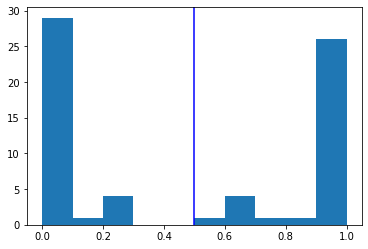

In [12]:
model.load_weights("denseweight.22.hdf5")
Y_hat = model.predict_proba(padded_test)
plt.hist(Y_hat)
_= plt.axvline(x=0.5,color = "blue")
plt.show()

In [13]:
pct_auc = roc_auc_score(Y_test,Y_hat) * 100.0
pct_auc

92.85714285714286

In [196]:
float_y_hat = []
for y in Y_hat:
    float_y_hat.append(y[0])
        
ydf =pd.DataFrame(list(zip(float_y_hat,Y_test)),columns=['y_hat','y'])
word_index = tokenizer.word_index
word_index = {k:(v-1) for k,v in word_index.items()}

index_word ={v:k for k,v in word_index.items()}

print(ydf[(ydf.y == 1) & (ydf.y_hat < 0.5)].head(10))
words = ' '.join(index_word[id] for id in padded_test[2])
words

       y_hat  y
2   0.002820  1
30  0.008968  1
59  0.217623  1


'included and her and staff leave writer someone her and staff someone on she answering i someone this separated checked he will face answering whilst called wa separated appointment so staff someone she way the yelling someone and police the and for supervisor if to contacted she groaning someone on wa again answering and and provided on someone to wa hospital want writer at went attended someone on and visible to writer at is someone disclosed wa again answering called a separated <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov>'

examine the sample sentences for test cases